In [122]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import Operator
from torchqc.common_matrices import sigmaY
from torchqc.dynamics import TDSE
from torchqc.common_functions import basis_operators
from torchqc.common_functions import fidelity

In [123]:
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

* Define Neural Network

In [124]:
max_control = 1.

class NeuralNet(nn.Module):
    def __init__(self, hidden_size, nb_hidden_layers = 2, input_size = 1, output_size = 1, activation_fn = nn.Tanh):
        super(NeuralNet, self).__init__()

        self.nb_hidden_layers = nb_hidden_layers
        self.hidden_layers = []
        self.hidden_act_layers = []

        # input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu_input = activation_fn()

        # hidden layers
        for layer in range(nb_hidden_layers):
            new_layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(new_layer)
            self.hidden_act_layers.append(activation_fn())
            
            # hidden layer parameters should be registered
            self.register_parameter(f"weights_{layer}", new_layer.weight)
            self.register_parameter(f"bias_{layer}", new_layer.bias)

        # output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.relu_input(out)

        for layer in range(self.nb_hidden_layers):
            out = self.hidden_layers[layer](out)
            out = self.hidden_act_layers[layer](out)

        out = self.output_layer(out)
        out = torch.clip(input=out, min=-max_control, max=max_control)

        return out

In [125]:
class Sin(nn.Module):
    """The sin activation function.
    """

    def __init__(self):
        """Initializer method.
        """
        super().__init__()

    def forward(self, input_):
        return torch.sin(input_)

* Start from basis state $\ket{0}$

In [126]:
dims = 3
basis_states = QuantumState.basis(dims)
state = basis_states[0].to(device)
state.normalize()

QuantumState (dims = 3 , tensor: tensor([[1.+0.j],
        [0.+0.j],
        [0.+0.j]], device='cuda:0', dtype=torch.complex128))

* Simulate dynamics with TDSE

In [127]:
T = 250
Dt = 0.5
time = np.arange(0, T + Dt, Dt, dtype = np.float32)
Γ = 1

In [128]:
# torch.manual_seed(123456)
BBNN = NeuralNet(hidden_size=150, input_size=1, output_size=2, nb_hidden_layers=4, activation_fn=Sin)
BBNN.to(device)

NeuralNet(
  (input_layer): Linear(in_features=1, out_features=150, bias=True)
  (relu_input): Sin()
  (output_layer): Linear(in_features=150, out_features=2, bias=True)
)

In [129]:
time_tensor = torch.from_numpy(time).reshape(len(time), 1).to(device)

u_pred = BBNN(time_tensor)

Ωp = u_pred[:, 0:1]
Ωp.unsqueeze_(-1)
Ωp.expand(len(time), dims, dims)

Ωs = u_pred[:, 1:2]
Ωs.unsqueeze_(-1)
Ωs.expand(len(time), dims, dims)

tensor([[[-0.0046, -0.0046, -0.0046],
         [-0.0046, -0.0046, -0.0046],
         [-0.0046, -0.0046, -0.0046]],

        [[ 0.0133,  0.0133,  0.0133],
         [ 0.0133,  0.0133,  0.0133],
         [ 0.0133,  0.0133,  0.0133]],

        [[ 0.0335,  0.0335,  0.0335],
         [ 0.0335,  0.0335,  0.0335],
         [ 0.0335,  0.0335,  0.0335]],

        ...,

        [[-0.0238, -0.0238, -0.0238],
         [-0.0238, -0.0238, -0.0238],
         [-0.0238, -0.0238, -0.0238]],

        [[-0.0395, -0.0395, -0.0395],
         [-0.0395, -0.0395, -0.0395],
         [-0.0395, -0.0395, -0.0395]],

        [[-0.0547, -0.0547, -0.0547],
         [-0.0547, -0.0547, -0.0547],
         [-0.0547, -0.0547, -0.0547]]], device='cuda:0',
       grad_fn=<ExpandBackward0>)

* Construct Hamiltonian and simulate dynamics with TDSE

In [130]:
projectors, transitions, labels = basis_operators(dims)
_, proj2, _ = projectors
trans12, trans13, trans23 = transitions

proj2 = proj2.to(device)
trans12 = trans12.to(device)
trans13 = trans13.to(device)
trans23 = trans23.to(device)
trans21 = trans12.dagger().to(device)
trans32 = trans23.dagger().to(device)

In [131]:
H1 = Operator(dims, (Ωp / 2) * ((trans12 + trans21).matrix.expand(len(Ωp), -1, -1)))
H2 = Operator(dims, (Ωs / 2) * ((trans23 + trans32).matrix.expand(len(Ωs), -1, -1)))
H_loss = -1j * (Γ / 2) * proj2
H_loss = Operator(dims, H_loss.matrix.expand(len(Ωp), -1, -1))

hamiltonian = H1 + H2 + H_loss

states = TDSE(state, hamiltonian, time, Dt)

In [132]:
def quantum_simulation(u_pred):
    projectors, transitions, labels = basis_operators(dims)
    _, proj2, _ = projectors
    trans12, trans13, trans23 = transitions

    proj2 = proj2.to(device)
    trans12 = trans12.to(device)
    trans13 = trans13.to(device)
    trans23 = trans23.to(device)
    trans21 = trans12.dagger().to(device)
    trans32 = trans23.dagger().to(device)

    Ωp = u_pred[:, 0:1]
    Ωp.unsqueeze_(-1)
    Ωp.expand(len(time), dims, dims)

    Ωs = u_pred[:, 1:2]
    Ωs.unsqueeze_(-1)
    Ωs.expand(len(time), dims, dims)

    H1 = Operator(dims, (Ωp / 2) * ((trans12 + trans21).matrix.expand(len(Ωp), -1, -1)))
    H2 = Operator(dims, (Ωs / 2) * ((trans23 + trans32).matrix.expand(len(Ωs), -1, -1)))
    H_loss = -1j * (Γ / 2) * proj2
    H_loss = Operator(dims, H_loss.matrix.expand(len(Ωp), -1, -1))

    hamiltonian = H1 + H2 + H_loss

    basis_states = QuantumState.basis(dims)
    initial_state = basis_states[0].to(device)

    states = TDSE(initial_state, hamiltonian, time, Dt)

    return states

def criterion_fidelity_custom(u_pred):
    basis_states = QuantumState.basis(dims)
    target_state = basis_states[2].to(device)

    states = quantum_simulation(u_pred)
    """ state2_pop = torch.tensor([(torch.abs(state.state_tensor)**2)[1] for state in states])

    state2_pop_loss = nn.MSELoss()(state2_pop, torch.zeros_like(state2_pop)) """
    
    achieved_state = states[-1]

    infidelity = 1 - fidelity(achieved_state, target_state)

    return infidelity

In [133]:
u_pred = BBNN(time_tensor)
criterion_fidelity_custom(u_pred)

tensor([[1.0000]], device='cuda:0', dtype=torch.float64,
       grad_fn=<RsubBackward1>)

* Training loop of the Deep NN using the defined objective function

In [134]:
def training():
    losses = []
    loss_threshold = 1e-4
    loss_float = 1
    iterations = 1000

    BBNN.train()

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(BBNN.parameters(), lr=learning_rate)
    print_interval = 100
    num_epochs = 0

    # while loss_float >= loss_threshold:
    for iter in range(iterations):
        # forward pass
        u_pred = BBNN(time_tensor)
        
        # calculate loss based on controls that produced by the nn
        loss = criterion_fidelity_custom(u_pred)
        losses.append(loss.detach().cpu().numpy())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if num_epochs % print_interval == 0:
            print("Epoch = ", num_epochs, ", Loss = ", loss.clone().detach().cpu().numpy())

        num_epochs += 1

        if losses[-1] < loss_threshold:
            break

In [135]:
training()

Epoch =  0 , Loss =  [[0.99998641]]
Epoch =  100 , Loss =  [[0.06321762]]
Epoch =  200 , Loss =  [[0.04095311]]
Epoch =  300 , Loss =  [[0.03490653]]
Epoch =  400 , Loss =  [[0.03360894]]
Epoch =  500 , Loss =  [[0.03295939]]
Epoch =  600 , Loss =  [[0.03213363]]
Epoch =  700 , Loss =  [[0.03205579]]
Epoch =  800 , Loss =  [[0.03206881]]
Epoch =  900 , Loss =  [[0.03208174]]


In [137]:
with torch.no_grad():
    epsilon = torch.normal(0, 0.1, size = (len(time_tensor), 1)).float().to(device)

    t_test = time_tensor + epsilon
    u_pred = BBNN(t_test)
    Ωp = u_pred[:, 0:1].detach().cpu().numpy()
    Ωp = np.array([omega[0] for omega in Ωp])
    
    Ωs = u_pred[:, 1:2].detach().cpu().numpy()
    Ωs = np.array([omega[0] for omega in Ωs])

    states = quantum_simulation(u_pred)


* Print Conctrol functions and Populations

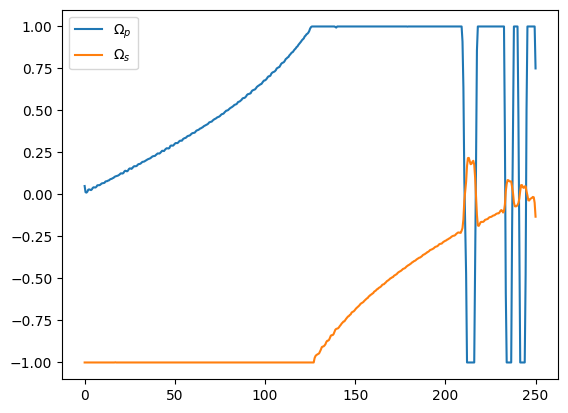

In [138]:
fig, ax = plt.subplots()

ax.plot(time, Ωp, label = r"$\Omega_p$")
ax.plot(time, Ωs, label = r"$\Omega_s$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

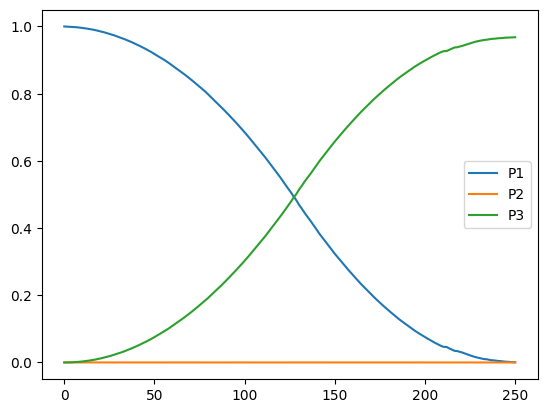

In [140]:
populations = np.array([(torch.abs(state.state_tensor)**2).detach().cpu().numpy() for state in states])

fig, ax = plt.subplots()

ax.plot(time, populations[:,0], label = "P1")
ax.plot(time, populations[:,1], label = "P2")
ax.plot(time, populations[:,2], label = "P3")
ax.legend()